# Earth Engine for gathering data

Google Earth Engine is a powerful tool for geospatial data analysis. Here, we will discuss how to use its Python API for gathering data from Landsat, Sentinel, and NAIP imagery.

To start off with, request access to Google Earth Engine at: [](https://earthengine.google.com/). This may take some time. Once approved, install the Python API and get credentials for using the API following [these instructions](https://developers.google.com/earth-engine/guides/python_install-conda#mac_6). Be sure to try out the test code they suggest to make sure Earth Engine is running successfully):

In [1]:
import ee

# Initialize the Earth Engine module.
ee.Initialize()

If the above code yields output, you'll know you're ready for to go!

## Selecting imagery



In [18]:
from geetools import batch

def download_S2_toLocal(bbox, name, scale=1):
    """
    downloads Sentinel 2 imagery from the specified bounding box and saves it as `name`
    """
    AOI = ee.Geometry.Rectangle(list(bbox), "EPSG:4326", False)

    collection = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterDate('2020-10-01', '2020-10-10')
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
        .filterBounds(AOI)
        .select(['B2', 'B3', 'B4'])
    )

    image = ee.Image(collection.mosaic()).clip(AOI)
    batch.image.toLocal(image, name, scale=scale, region=AOI)
    return collection

x = 33.6319
y = -87.0597

lat = [x-0.004, x+0.004]
lon = [y-0.004, y+0.004]
bbox = [lon[0], lat[0], lon[1], lat[1]]
name = 's2sample'
image = download_S2_toLocal(bbox, name, scale=1)

In [ ]:
# All metadata.
print('All metadata:')
# print(image.getInfo())

In [19]:
import zipfile
path_to_zip_file = 's2sample.zip'
directory_to_extract_to = 's2sample'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [20]:
import rasterio

def stack_bands_s2(name, outname):
    file_list = [name + '.B4.tif', name + '.B3.tif', name + '.B2.tif']

    # Read metadata of first file
    with rasterio.open(file_list[0]) as src0:
        meta = src0.meta

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer and write it to stack
    with rasterio.open(outname, 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

outname = "stacked_s2_sample.tif"
stack_bands_s2('s2sample/download',outname)

In [252]:
with rasterio.open('s2sample/download.B3.tif') as ds:
    arr = ds.read()  # read all raster values

print(arr.shape)  # this is a 3D numpy array, with dimensions [band, row, col]

(1, 892, 891)


In [253]:
arr

array([[[1726, 1726, 1726, ...,  899,  899,  899],
        [1726, 1726, 1726, ...,  899,  899,  899],
        [1726, 1726, 1726, ...,  899,  899,  899],
        ...,
        [ 507,  507,  507, ..., 1202, 1202, 1202],
        [ 507,  507,  507, ..., 1202, 1202, 1202],
        [ 507,  507,  507, ..., 1202, 1202, 1202]]], dtype=uint16)

In [239]:
np.transpose(arr).shape

(891, 892, 1)

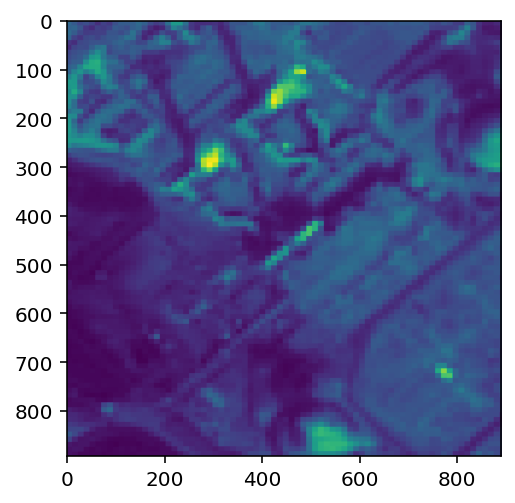

In [240]:
plt.imshow(arr[0])

In [231]:
t_arr = np.transpose(arr)
t_arr_bw = np.average(t_arr, weights=[0.1140, 0.5870, 0.2989], axis=2)

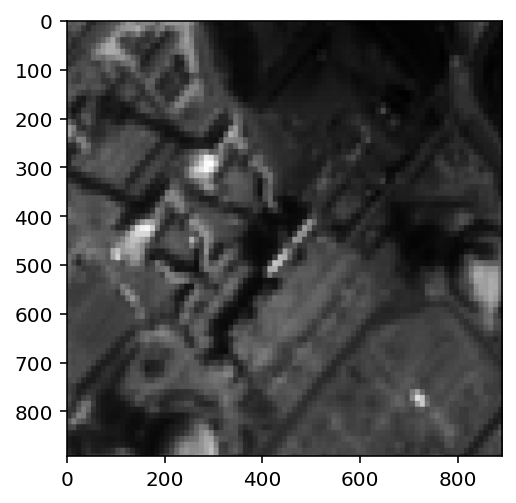

In [232]:
plt.imshow(t_arr_bw, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


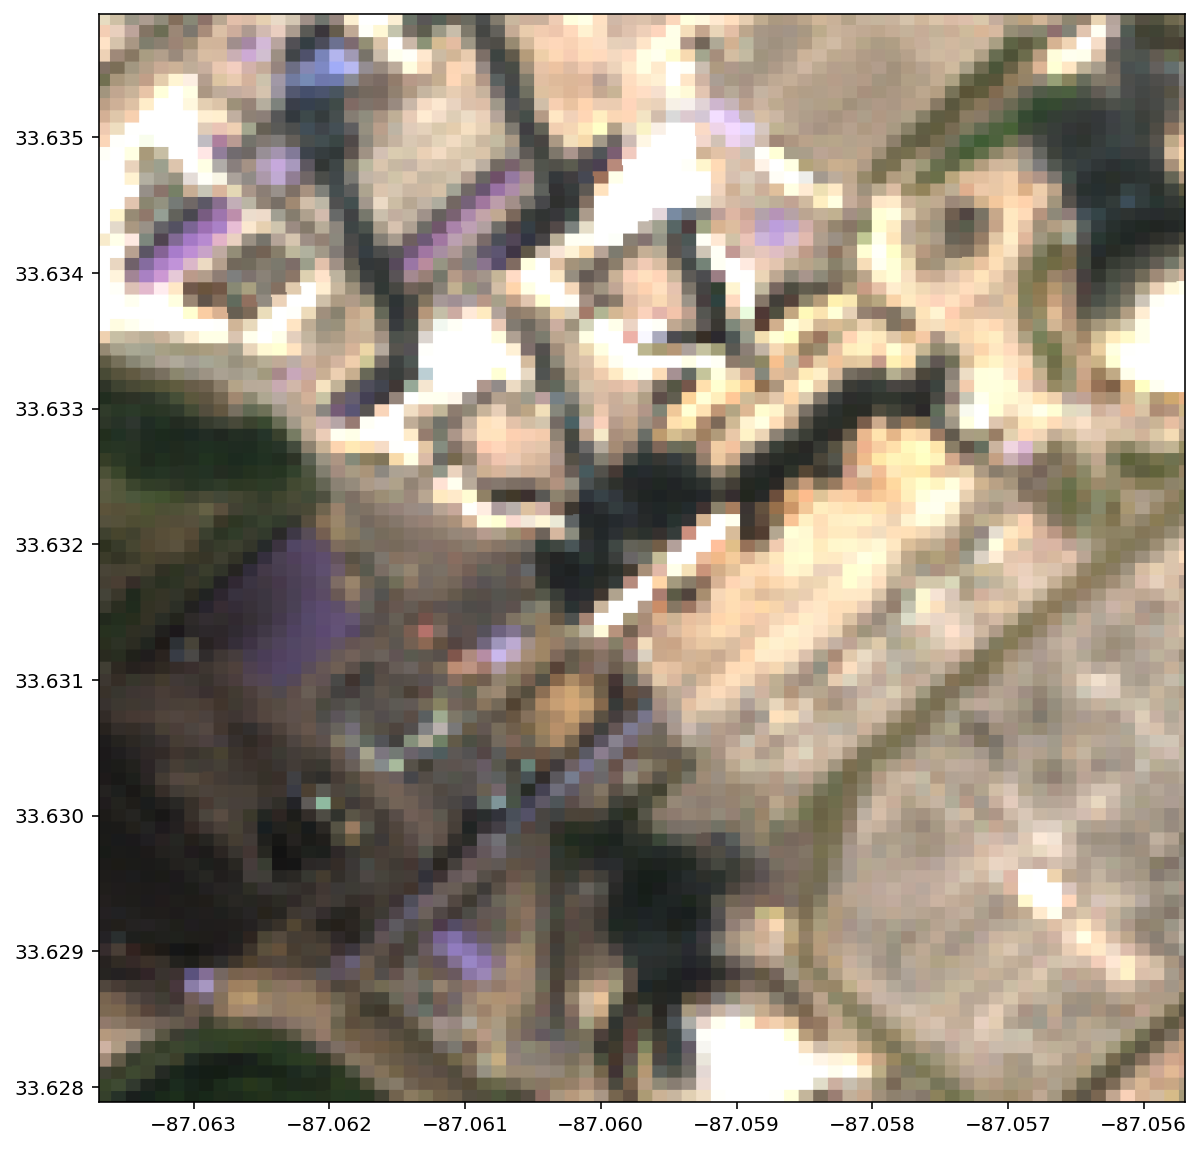

In [144]:
# Plot the example
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from rasterio.plot import show

fig, ax = plt.subplots(num='main', figsize=(10,10))

from rasterio.plot import show
data = rasterio.open(outname)

# show(data.read([1,2,3]).astype('float')/4096, transform=data.transform, ax=ax)
show(data.read([1,2,3]).astype('float')/2000, transform=data.transform, ax=ax)
plt.savefig(r'miller.jpg')

# show(data.read([1,2,3]).astype('float')/255, transform=data.transform, ax=ax)

In [33]:
import numpy as np

In [153]:
uint_img = img_array.astype('uint8')

grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)

In [203]:
img_array = np.asarray(data.read([1,2,3]).astype('float'))

In [182]:
img_array.shape

(3, 892, 891)

In [199]:
img_array

array([[[1814., 1814., 1814.],
        [1814., 1814., 1814.],
        [1814., 1814., 1814.],
        ...,
        [ 866.,  866.,  866.],
        [ 866.,  965.,  965.],
        [ 965.,  965.,  965.]],

       [[1814., 1814., 1814.],
        [1814., 1814., 1814.],
        [1814., 1814., 1814.],
        ...,
        [ 866.,  866.,  866.],
        [ 866.,  965.,  965.],
        [ 965.,  965.,  965.]],

       [[1814., 1814., 1814.],
        [1814., 1814., 1814.],
        [1814., 1814., 1814.],
        ...,
        [ 866.,  866.,  866.],
        [ 866.,  965.,  965.],
        [ 965.,  965.,  965.]],

       ...,

       [[ 340.,  340.,  340.],
        [ 340.,  340.,  340.],
        [ 340.,  340.,  340.],
        ...,
        [1074., 1074., 1074.],
        [1074.,  943.,  943.],
        [ 943.,  943.,  943.]],

       [[ 340.,  340.,  340.],
        [ 340.,  340.,  340.],
        [ 340.,  340.,  340.],
        ...,
        [1074., 1074., 1074.],
        [1074.,  943.,  943.],
        [ 943.,

In [148]:
img_arr_bw_weighted = np.average(img_array, weights=[0.1140, 0.5870, 0.2989], axis=0)

In [197]:
B = img_array[0] * 0.1140
G = img_array[1] * 0.5870
R = img_array[2] * 0.2989

img_arr_bw = np.mean(np.array([B,G,R]), axis=3)

AxisError: axis 3 is out of bounds for array of dimension 3

In [198]:
img_arr_bw.shape

(891, 3)

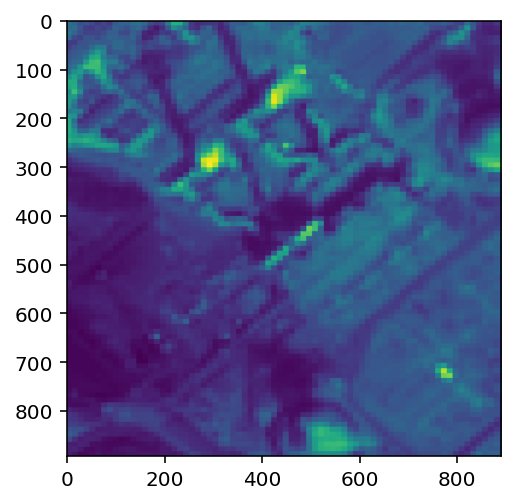

In [210]:
plt.imshow(arr[1])
plt.show()

In [90]:
# from PIL import Image
# im = Image.fromarray(img_arr_bw)
# im.save("test.jpg")

OSError: cannot write mode F as JPEG

In [51]:
import cv2

In [78]:
rgb_image = cv2.imread('miller.jpg')
grayscale_img = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

In [67]:
cv2.imshow('Gray image', grayscale_img)

(720, 720)


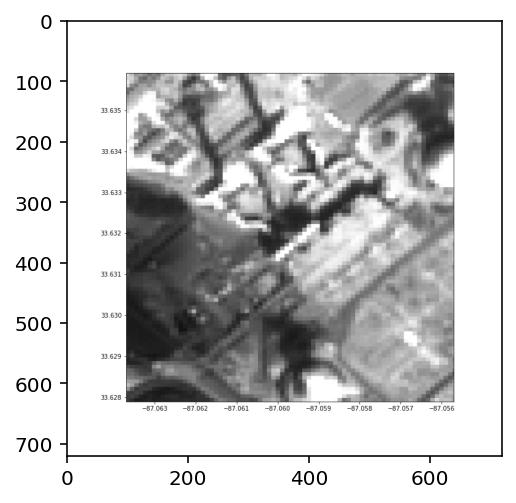

In [79]:
h,w = grayscale_img.shape[:2]
print(grayscale_img.shape)
plt.imshow(grayscale_img,cmap='gray')
plt.show()